In [287]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [336]:
#import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler #to use logistic model , we have to create dummy values
from sklearn.model_selection import train_test_split
#importing the models
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#for checking the accuracies
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
#regularization
from sklearn.pipeline import make_pipeline

In [232]:
#load dataset and arrange it using delimiter option
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cardiovascular_Disease_Prediction/cardio_train.csv' ,delimiter = ';')

In [233]:
#read first 5 rows in the dataset
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [234]:
#to see the no of rows(observations) and columns
data.shape

(70000, 13)

 There's 7000 rows and 13 cloumns
 Id variable should be primary and cardio variable is a target value
 So totally there should be 11 columns

In [235]:
#data wrangling = missing datas and dublicated stuff cleaning
data.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

No missing values there

In [236]:
#see duplicates
data.duplicated().sum()

0

No duplicates too

Outliers will only define for numerical variables
There only 5 numericals variable
ex-age,height,weight,ap_hi,ap_lo...
Others are categorical ones

<Axes: >

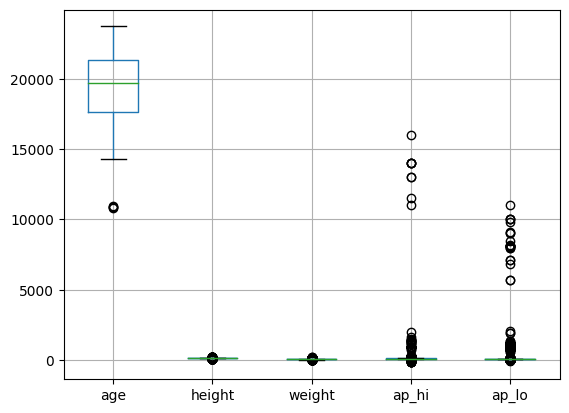

In [237]:
#to see outliers
data[["age","height","weight","ap_hi","ap_lo"]].boxplot()

In [238]:
#now age is displaying in days, we have to convert that into years
data["age"] = (data["age"]/365).values.astype(int)

And when days convert into years it shows in decimal points, avoid that can use values.astype(int)

In [239]:
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [240]:
#instead of getting height and weight separately, we can get BMI value
data["bmi"] = data["weight"]/((data["height"]/100)**2)

In [241]:
#drop the height and weight columns since now there is bmi column
data.drop(["height","weight"],axis=1, inplace=True)

In [242]:
data.head()

,id,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,2,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,140,90,3,1,0,0,1,1,34.927679
2,2,51,1,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,150,100,1,1,0,0,1,1,28.710479
4,4,47,1,100,60,1,1,0,0,0,0,23.011177


In [243]:
#to remove id column
#data.drop(["id"],axis=1,inplace=True)

In [244]:
#data.head()

<Axes: >

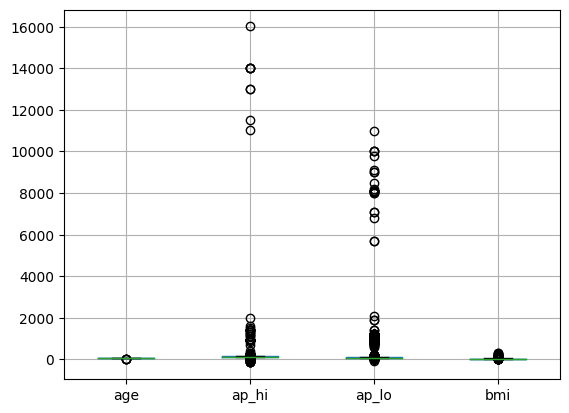

In [245]:
#to see the new outliers
data[["age","ap_hi","ap_lo","bmi"]].boxplot()

In [246]:
data.shape

(70000, 12)

In [247]:
#to remove outliers 1.5 IQR rule
data_num=data[["age","ap_hi","ap_lo","bmi"]]

In [248]:
Q1 = data_num.quantile(0.25) #1st quantile
Q3 = data_num.quantile(0.75) #2nd quantile

IQR = Q3 - Q1

In [249]:
IQR   #when find iqr we just find the rows where we are having outlier

age      10.000000
ap_hi    20.000000
ap_lo    10.000000
bmi       6.347107
dtype: float64

In [250]:
#to see the outliers
out_rows = ((data_num<(Q1-1.5*IQR))|(data_num>(Q3+1.5*IQR))).any(axis=1) #any = at least #true means there is an outlier

In [251]:
data = data[~out_rows]   #Tilde symbol used to get opposite

<Axes: >

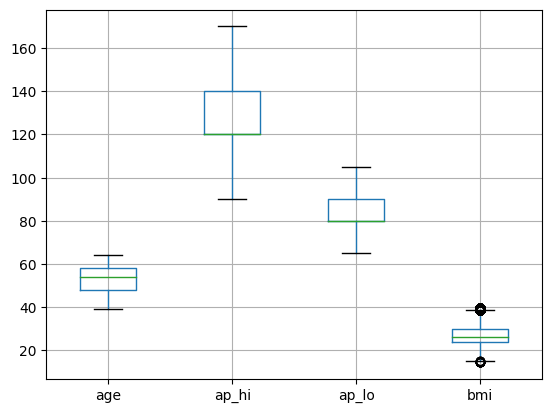

In [252]:
data[["age","ap_hi","ap_lo","bmi"]].boxplot()  #now this is outliers free dataframe

#descriptive analysis

In [253]:
data[["age","ap_hi","ap_lo","bmi"]].describe()

,age,ap_hi,ap_lo,bmi
count,62745.000000,62745.000000,62745.000000,62745.000000
mean,52.882413,126.404319,81.689537,27.034727
std,6.746333,14.296927,7.673500,4.406103
min,39.000000,90.000000,65.000000,14.479500
25%,48.000000,120.000000,80.000000,23.875115
50%,54.000000,120.000000,80.000000,26.222222
75%,58.000000,140.000000,90.000000,29.757585
max,64.000000,170.000000,105.000000,39.736121


In [254]:
data["cardio"].value_counts()

0    31783
1    30962
Name: cardio, dtype: int64

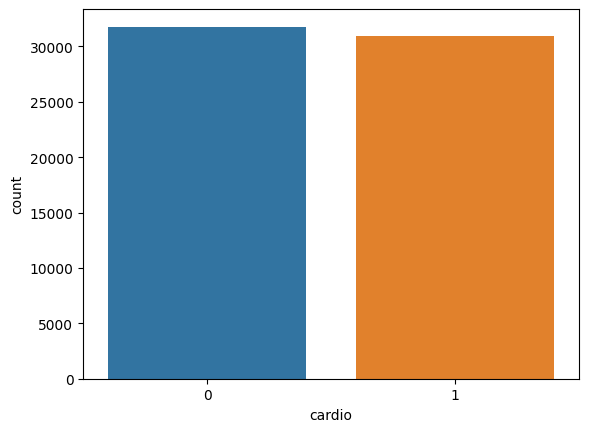

In [255]:
sns.countplot(data=data, x="cardio", order=[0, 1])  # Specify the order of categories
plt.show()

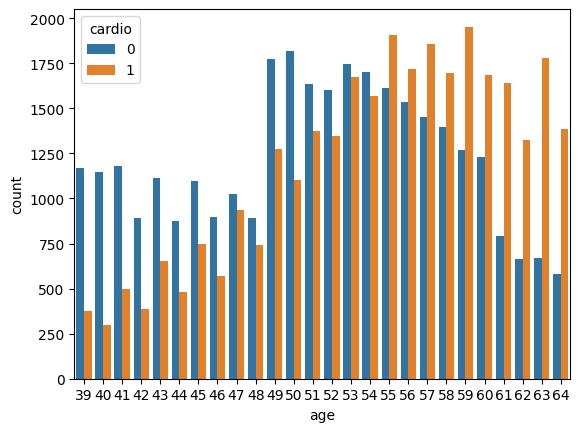

In [256]:
sns.countplot(data=data, x="age", hue="cardio")
plt.show()

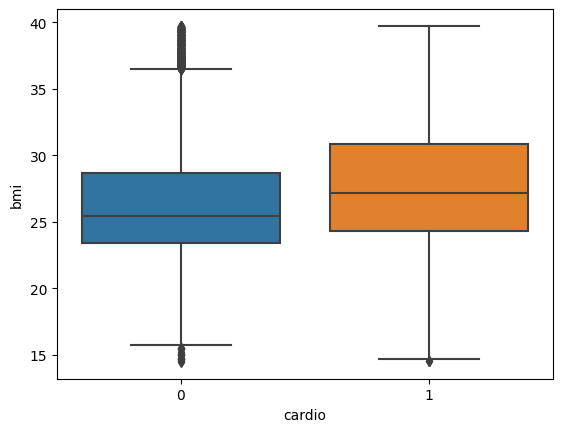

In [257]:
sns.boxplot(x="cardio", y="bmi",data=data)
plt.show()

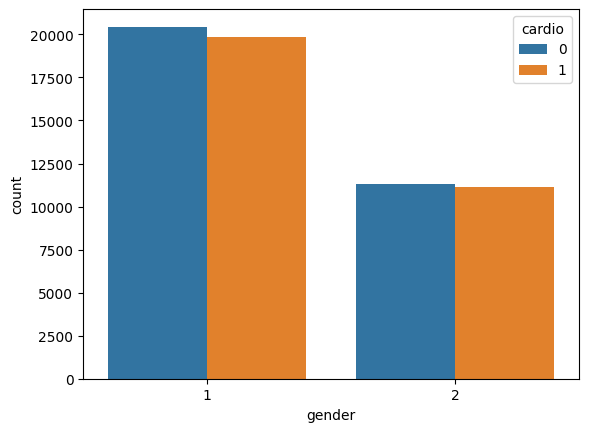

In [258]:
sns.countplot(data=data, x="gender", hue="cardio")   # 1= women, 2 = men
plt.show()

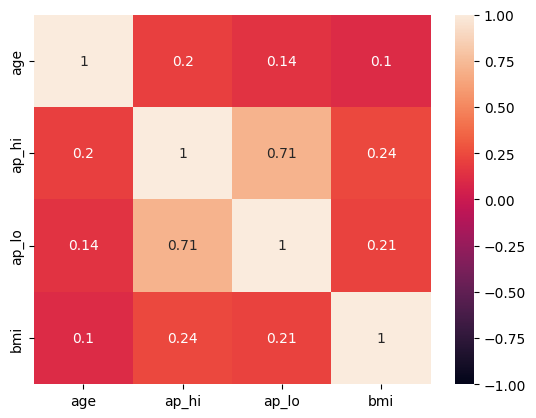

In [259]:
#to see correlation
sns.heatmap(data[["age","ap_hi","ap_lo","bmi"]].corr(), annot=True, vmin=-1, vmax=+1)
plt.show()

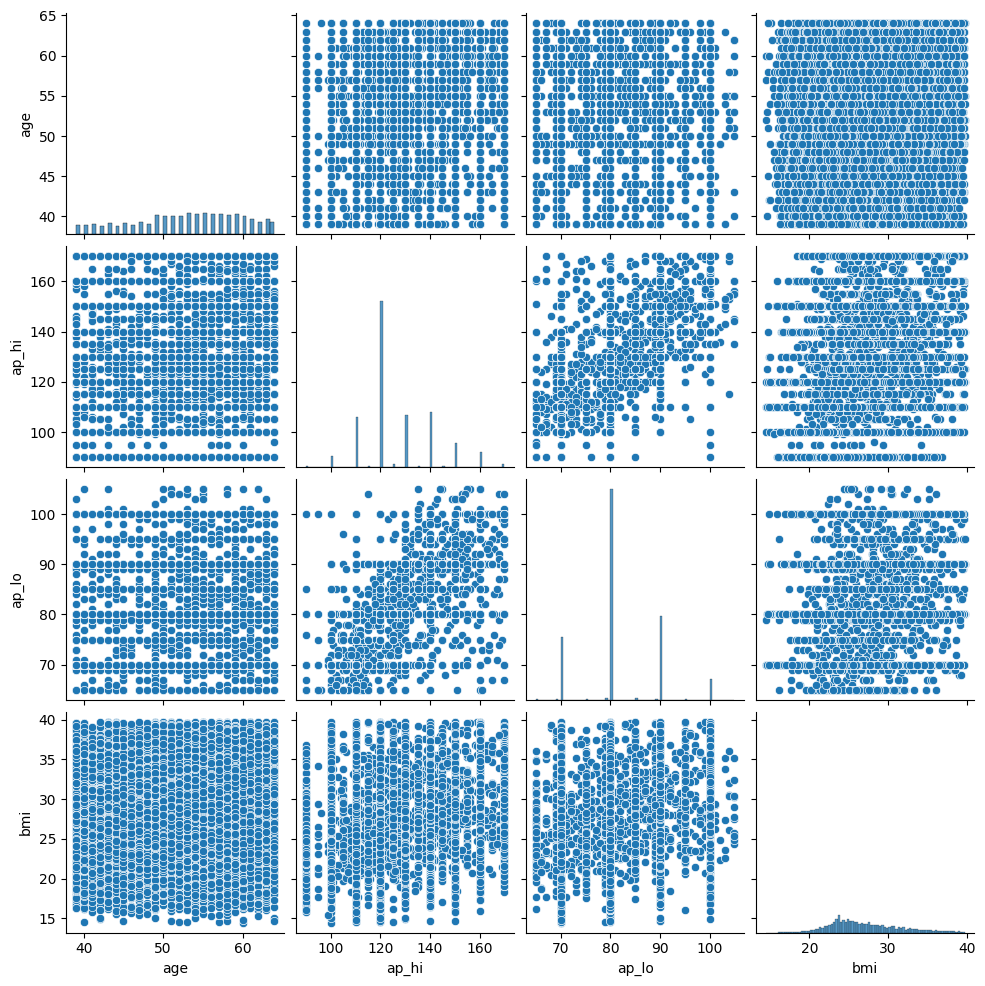

In [260]:
#to plug the numerical things to the pairplot
sns.pairplot(data[["age","ap_hi","ap_lo","bmi"]])
plt.show()

In [261]:
df = data[["age","ap_hi","ap_lo","bmi"]]
df["cardio"]=["Yes" if m==1 else "No" for m in data ["cardio"]]
df.head()

<ipython-input-261-e8200c2c8fad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cardio"]=["Yes" if m==1 else "No" for m in data ["cardio"]]


,age,ap_hi,ap_lo,bmi,cardio
0,50,110,80,21.967120,No
1,55,140,90,34.927679,Yes
2,51,130,70,23.507805,Yes
3,48,150,100,28.710479,Yes
5,60,120,80,29.384676,No


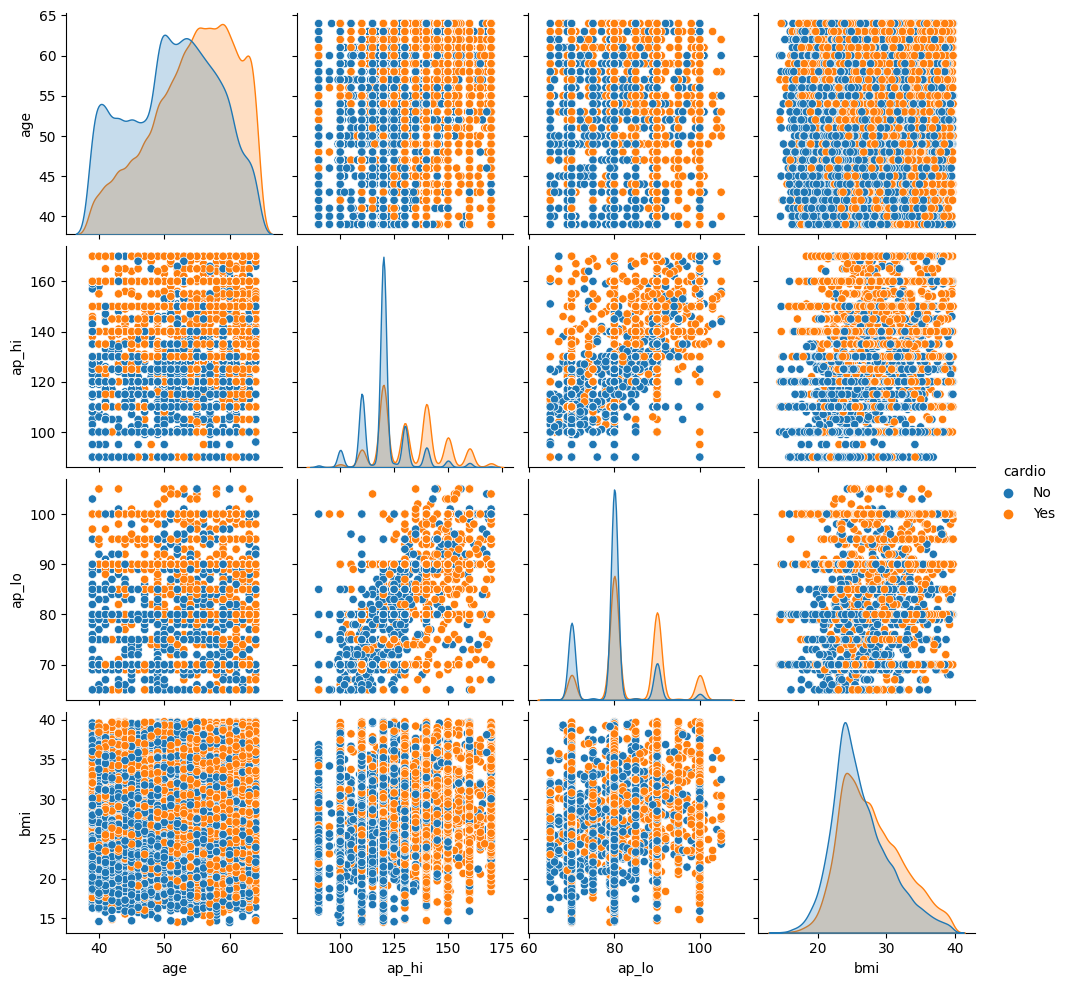

In [262]:
sns.pairplot(df,hue="cardio")
plt.show()

In [263]:
data.head()

,id,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,2,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,140,90,3,1,0,0,1,1,34.927679
2,2,51,1,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,150,100,1,1,0,0,1,1,28.710479
5,8,60,1,120,80,2,2,0,0,0,0,29.384676


In [264]:
data.drop("id",axis=1,inplace=True)

In [265]:
data.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,110,80,1,1,0,0,1,0,21.967120
1,55,1,140,90,3,1,0,0,1,1,34.927679
2,51,1,130,70,3,1,0,0,0,1,23.507805
3,48,2,150,100,1,1,0,0,1,1,28.710479
5,60,1,120,80,2,2,0,0,0,0,29.384676


In [274]:
#get numerical variables from of the table
data.reindex(columns=["age","ap_hi","ap_lo","bmi","gender","cholesterol","gluc","smoke","alco","active","cardio"])

,age,ap_hi,ap_lo,bmi,gender,cholesterol,gluc,smoke,alco,active,cardio
0,50,110,80,21.967120,1,1,1,0,0,1,0
1,55,140,90,34.927679,0,3,1,0,0,1,1
2,51,130,70,23.507805,0,3,1,0,0,0,1
3,48,150,100,28.710479,1,1,1,0,0,1,1
5,60,120,80,29.384676,0,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
69993,53,130,90,23.661439,0,1,1,0,0,1,1
69994,57,150,80,29.384757,0,1,1,0,0,1,1
69995,52,120,80,26.927438,1,1,1,1,0,1,0
69998,61,135,80,27.099251,0,1,2,0,0,0,1


In [276]:
data.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,1,110,80,1,1,0,0,1,0,21.967120
1,55,0,140,90,3,1,0,0,1,1,34.927679
2,51,0,130,70,3,1,0,0,0,1,23.507805
3,48,1,150,100,1,1,0,0,1,1,28.710479
5,60,0,120,80,2,2,0,0,0,0,29.384676


In [277]:
data["cardio"].value_counts()    #checking variables

0    31783
1    30962
Name: cardio, dtype: int64

In [272]:
#to make dummy
le = LabelEncoder()
data["gender"]=le.fit_transform(data["gender"])

In [273]:
data.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,1,110,80,1,1,0,0,1,0,21.967120
1,55,0,140,90,3,1,0,0,1,1,34.927679
2,51,0,130,70,3,1,0,0,0,1,23.507805
3,48,1,150,100,1,1,0,0,1,1,28.710479
5,60,0,120,80,2,2,0,0,0,0,29.384676


# Model Creation

In [278]:
import pandas as pd
df = pd.DataFrame({"P":["a","a","b"], "Q":["x","y","x"]})

In [279]:
df

,P,Q
0,a,x
1,a,y
2,b,x


In [281]:
pd.get_dummies(df)

,P_a,P_b,Q_x,Q_y
0,1,0,1,0
1,1,0,0,1
2,0,1,1,0


In [284]:
df = pd.DataFrame({"P":["1","1","2"], "Q":["1","2","1"]})

In [285]:
pd.get_dummies(df)

,P_1,P_2,Q_1,Q_2
0,1,0,1,0
1,1,0,0,1
2,0,1,1,0


In [300]:
ohe=OneHotEncoder()

In [301]:
ohot_encoded1=ohe.fit_transform(data["cholesterol"].values.reshape(len(data["cholesterol"].values),1)).toarray()
ohot_encoded1=ohot_encoded1[:,1:].astype(int)
df_ohot1=pd.DataFrame(ohot_encoded1,columns=["Above Nor Chol","Well Above Chol"])
df_ohot1

,Above Nor Chol,Well Above Chol
0,0,0
1,0,1
2,0,1
3,0,0
4,1,0
...,...,...
62740,0,0
62741,0,0
62742,0,0
62743,0,0


In [302]:
ohot_encoded2=ohe.fit_transform(data["gluc"].values.reshape(len(data["gluc"].values),1)).toarray()
ohot_encoded2=ohot_encoded1[:,1:].astype(int)
df_ohot2=pd.DataFrame(ohot_encoded1,columns=["Above Nor gluc","Well Above gluc"])
df_ohot2

,Above Nor gluc,Well Above gluc
0,0,0
1,0,1
2,0,1
3,0,0
4,1,0
...,...,...
62740,0,0
62741,0,0
62742,0,0
62743,0,0


In [303]:
data

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,1,110,80,1,1,0,0,1,0,21.967120
1,55,0,140,90,3,1,0,0,1,1,34.927679
2,51,0,130,70,3,1,0,0,0,1,23.507805
3,48,1,150,100,1,1,0,0,1,1,28.710479
5,60,0,120,80,2,2,0,0,0,0,29.384676
...,...,...,...,...,...,...,...,...,...,...,...
69993,53,0,130,90,1,1,0,0,1,1,23.661439
69994,57,0,150,80,1,1,0,0,1,1,29.384757
69995,52,1,120,80,1,1,1,0,1,0,26.927438
69998,61,0,135,80,1,2,0,0,0,1,27.099251


In [307]:
#resetting the indexes
data.reset_index(inplace=True)
data

,index,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,1,110,80,1,1,0,0,1,0,21.967120
1,1,55,0,140,90,3,1,0,0,1,1,34.927679
2,2,51,0,130,70,3,1,0,0,0,1,23.507805
3,3,48,1,150,100,1,1,0,0,1,1,28.710479
4,4,60,0,120,80,2,2,0,0,0,0,29.384676
...,...,...,...,...,...,...,...,...,...,...,...,...
62740,62740,53,0,130,90,1,1,0,0,1,1,23.661439
62741,62741,57,0,150,80,1,1,0,0,1,1,29.384757
62742,62742,52,1,120,80,1,1,1,0,1,0,26.927438
62743,62743,61,0,135,80,1,2,0,0,0,1,27.099251


In [308]:
#removing the outlier index column again
data.drop("index",axis=1,inplace=True)
data.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,1,110,80,1,1,0,0,1,0,21.967120
1,55,0,140,90,3,1,0,0,1,1,34.927679
2,51,0,130,70,3,1,0,0,0,1,23.507805
3,48,1,150,100,1,1,0,0,1,1,28.710479
4,60,0,120,80,2,2,0,0,0,0,29.384676


Separating the cardio column and add df_ohot1 and df_hot2 columns to the dataset.

In [310]:
x=pd.concat([data.iloc[:,:10],df_ohot1,df_ohot2],axis=1)
x.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Above Nor Chol,Well Above Chol,Above Nor gluc,Well Above gluc
0,50,1,110,80,1,1,0,0,1,0,0,0,0,0
1,55,0,140,90,3,1,0,0,1,1,0,1,0,1
2,51,0,130,70,3,1,0,0,0,1,0,1,0,1
3,48,1,150,100,1,1,0,0,1,1,0,0,0,0
4,60,0,120,80,2,2,0,0,0,0,1,0,1,0


In [311]:
#removing the cholesterol and gluc columns
x.drop(["cholesterol","gluc"],axis=1,inplace=True)
x.head()

,age,gender,ap_hi,ap_lo,smoke,alco,active,cardio,Above Nor Chol,Well Above Chol,Above Nor gluc,Well Above gluc
0,50,1,110,80,0,0,1,0,0,0,0,0
1,55,0,140,90,0,0,1,1,0,1,0,1
2,51,0,130,70,0,0,0,1,0,1,0,1
3,48,1,150,100,0,0,1,1,0,0,0,0
4,60,0,120,80,0,0,0,0,1,0,1,0


In [312]:
x=x.values
y=data.iloc[:,10].values

Standarising the Neumerical values

In [313]:
sc=StandardScaler()

In [314]:
x[:,:4]=sc.fit_transform(x[:,:4])

In [315]:
x[:,:4]

array([[ 0,  1, -1,  0],
       [ 0,  0,  0,  1],
       [ 0,  0,  0, -1],
       ...,
       [ 0,  1,  0,  0],
       [ 1,  0,  0,  0],
       [ 0,  0,  0,  0]])

Spliting the Data set

In [317]:
#columns except cardio
x

array([[ 0,  1, -1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  1,  0,  1],
       [ 0,  0,  0, ...,  1,  0,  1],
       ...,
       [ 0,  1,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  0]])

In [318]:
#cardio column
y

array([21.96712018, 34.92767916, 23.50780533, ..., 26.92743764,
       27.09925101, 24.91349481])

In [329]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [330]:
x_train.shape

(50196, 12)

In [331]:
x_test.shape

(12549, 12)

### Creating the Model Objects

In [332]:
# Base models with regularization
model1 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=50))
model2 = make_pipeline(StandardScaler(), LogisticRegression(C=1)) #C = Regulation parameter
model3 = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=1, probability=True))
model4 = RandomForestClassifier(n_estimators=500)


T1=("knn",model1)
T2=("lgr",model2)
T3=("svm",model3)
T4=("rf",model4)

model=VotingClassifier(estimators=[T1,T2,T3,T4],voting="hard")

fiting the model

In [ ]:
model.fit(x_train,y_train)

In [ ]:
y_predict=model.predict(x_test)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
print(classification_report(y_test,y_pred))